# Projeto B - Previsão de Faturamento

<sub>Projeto para a disciplina de **Estatística** (Módulo 4) do Data Science Degree (turma de julho de 2020)</sub>

## Equipe

* Felipe Lima de Oliveira
* Mário Henrique Romagna Cesa
* Tsuyioshi Valentim Fukuda
* Fernando Raineri Monari

Link para [projeto no Github](https://github.com/flimao/case-previsao-faturamento)

## Introdução

Este notebook contém a análise exploratória inicial dos dados.

In [1]:
# importação de bibliotecas
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import json

# importação de bibliotecas de análise
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
from pmdarima.arima import auto_arima

# teste para verificar estacionariedade (Dickey-Fuller: https://en.wikipedia.org/wiki/Dickey%E2%80%93Fuller_test)
from statsmodels.tsa.stattools import adfuller

# metricas 
from sklearn.metrics import mean_absolute_percentage_error as smape, mean_squared_error as smse, mean_absolute_error as smae 

# pacote com funções para análise desse projeto
import os
cwd = os.getcwd()
os.chdir("../")
import py_scripts.plots, py_scripts.transform
os.chdir(cwd)

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120
mpl.rcParams['figure.figsize'] = (10, 4)

## Importação dos dados e análise inicial

Inicialmente, vamos importar e ver a aparência geral dos dados:

* número e nome de colunas
* qual o tipo de dados de cada coluna
* Algumas linhas do dataset

In [2]:
# importar base e iniciar a análise inicial
ts_raw = pd.read_csv(r'../data/sim_ts.txt', sep = '\t')
ts_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 511 entries, 0 to 510
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   vlr      511 non-null    float64
 1   date     511 non-null    object 
 2   produto  511 non-null    object 
dtypes: float64(1), object(2)
memory usage: 12.1+ KB


In [3]:
ts_raw.describe()

,vlr
count,5.110000e+02
mean,4.187929e+08
std,6.272376e+08
min,0.000000e+00
25%,6.472878e+05
50%,2.261791e+07
75%,1.028848e+09
max,1.990000e+09


In [4]:
ts_raw.sample(5).sort_index()

,vlr,date,produto
97,1.571210e+09,2018-01-01,alimenticio
154,1.593797e+08,2015-12-01,transporte
269,7.775421e+05,2013-08-01,auxilio_final_de_ano
305,1.028600e+06,2016-08-01,auxilio_final_de_ano
507,2.665517e+07,2021-07-01,saude


### Limpeza dos dados

Vamos definir algumas funções de limpeza dos dados.

Ao final desse processo, teremos três estruturas de dados:

- um *dataframe* `ts` associando os meses aos faturamentos e aos produtos;
- um dicionário `tsd` cujas chaves serão os produtos e os valores serão *Series* associando meses e faturamentos (contanto desde o lançamento do produto); e
- um *dataframe* `tswide` onde cada coluna corresponde à série histórica de um produto.

Ao dicionário `tsd` será adicionada uma chave, `total`, contendo a soma dos faturamentos de todos os produtos mês a mês.

In [5]:
# limpeza 1: conversão de tipos

def conversao_tipos(df):
    df = df.copy()

    df['date'] = df['date'].astype('datetime64[ns]')
    df['produto'] = df['produto'].astype('category')
    return df

# limpeza 2: setar a coluna de data como indice
def setar_indice_data(df):
    df = df.copy()

    s = df.set_index('date')['vlr']

    return s

# limpeza 3: gerar dados de meses faltantes

def gerar_dados_faltantes(s):
    s = s.copy()

    s = s.asfreq('MS')

    return s

# limpeza 4: preencher missings
def preencher_missings(s):
    s = s.copy()

    # s = s.interpolate()

    return s

# executar limpeza para o DF ts
# não é possível setar a data como índice porque há multiplas entradas com mesmo mês.
# isso geraria problemas para funções de agregação (groupby's etc) e JOIN's.
# logo, para o 
ts = (ts_raw
    .pipe(conversao_tipos)
)


In [6]:
ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 511 entries, 0 to 510
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   vlr      511 non-null    float64       
 1   date     511 non-null    datetime64[ns]
 2   produto  511 non-null    category      
dtypes: category(1), datetime64[ns](1), float64(1)
memory usage: 8.8 KB


In [7]:
ts.sample(10).sort_index()

,vlr,date,produto
7,9.930611e+08,2010-07-01,alimenticio
134,1.913098e+09,2021-02-01,alimenticio
226,6.544292e+05,2010-01-01,auxilio_final_de_ano
227,6.228833e+05,2010-02-01,auxilio_final_de_ano
232,5.264609e+05,2010-07-01,auxilio_final_de_ano
265,6.206476e+05,2013-04-01,auxilio_final_de_ano
343,2.176945e+06,2019-10-01,auxilio_final_de_ano
410,9.985266e+04,2017-04-01,bonificacao
451,0.000000e+00,2016-11-01,saude
489,2.432153e+07,2020-01-01,saude


Vamos agora construir o dicionário `tsd` e o dataframe `tswide`:

In [8]:
produtos = ts['produto'].cat.categories

tsd = {}
for produto in produtos:
    ts_produto = ts[ts['produto'] == produto]

    # finalizar limpeza para Series dentro do dicionário
    s_prod = (ts_produto
        .pipe(setar_indice_data)
        .pipe(gerar_dados_faltantes)
        .pipe(preencher_missings)
    )
    s_prod.name = f'faturamento_{produto}'
    tsd[produto] = s_prod

tswide = pd.DataFrame(tsd)

sprodtotal = tswide.sum(axis = 1)
sprodtotal.name = 'faturamento_total'
tsd['total'] = sprodtotal

for produto, s in tsd.items():
    print(f"Quantidade de dados faltantes para o produto '{produto}': {s.isna().sum()}")
    print(f"Lançamento do produto '{produto}': {s.index[0].strftime('%Y-%m-%d')}")
    print('')

# confirmação do dataframe limpo
# ts.info()

Quantidade de dados faltantes para o produto 'alimenticio': 0
Lançamento do produto 'alimenticio': 2009-12-01

Quantidade de dados faltantes para o produto 'auxilio_final_de_ano': 0
Lançamento do produto 'auxilio_final_de_ano': 2009-12-01

Quantidade de dados faltantes para o produto 'bonificacao': 30
Lançamento do produto 'bonificacao': 2012-01-01

Quantidade de dados faltantes para o produto 'saude': 0
Lançamento do produto 'saude': 2016-11-01

Quantidade de dados faltantes para o produto 'transporte': 0
Lançamento do produto 'transporte': 2015-01-01

Quantidade de dados faltantes para o produto 'total': 0
Lançamento do produto 'total': 2009-12-01



#### Tratamento de valores faltantes

Há alguns padrões interessantes de valores faltantes para alguns produtos:

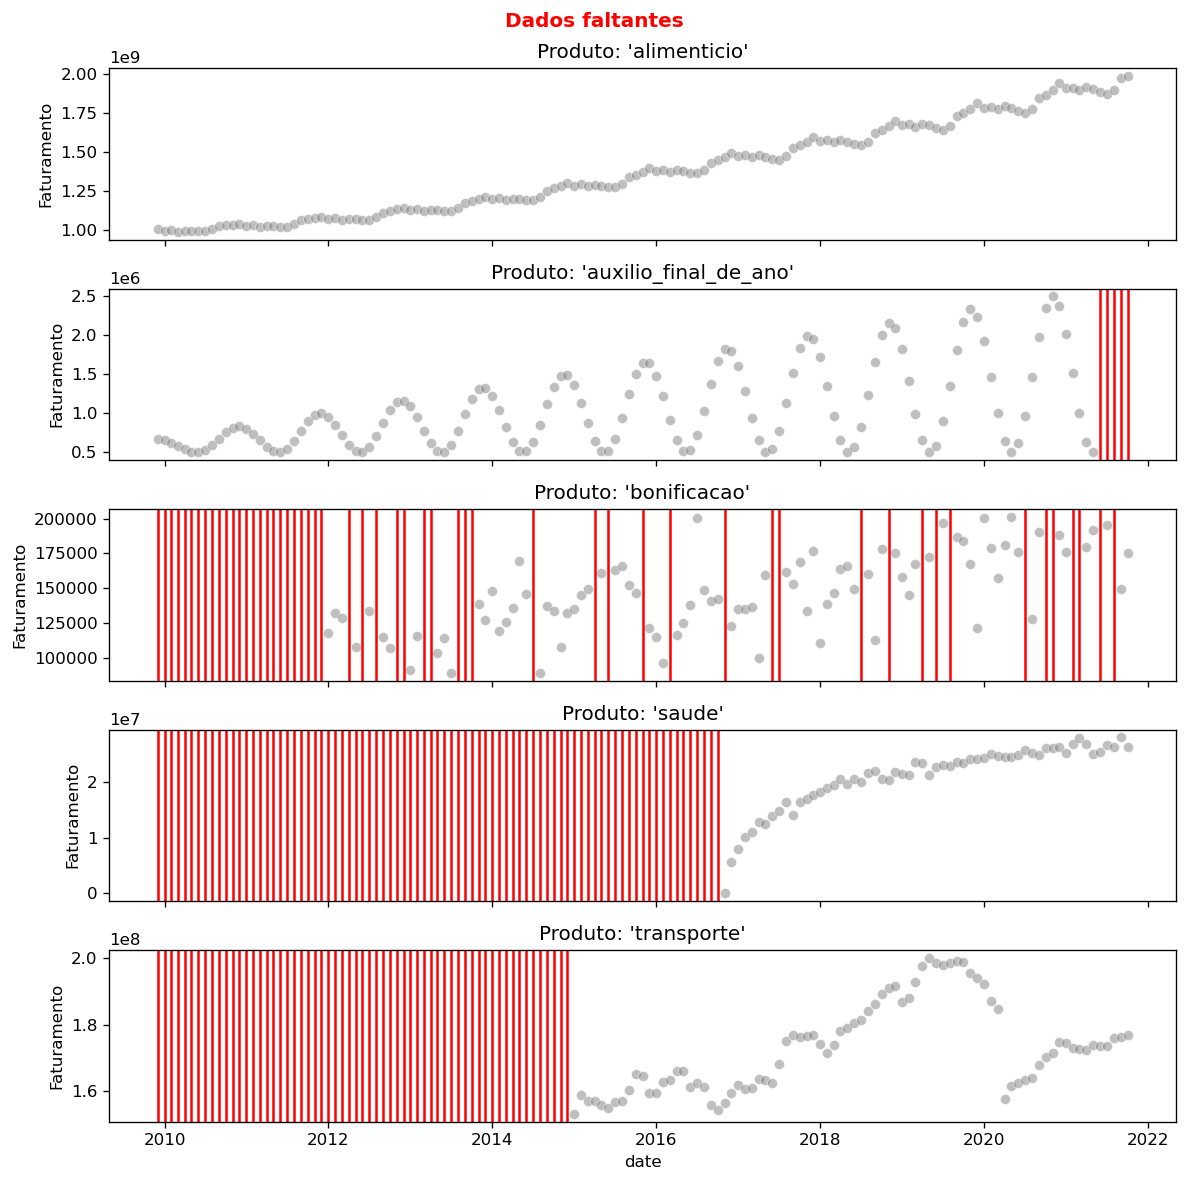

In [9]:
py_scripts.plots.dados_faltantes(tswide)

In [10]:
tswide.index[tswide['auxilio_final_de_ano'].isna()]

DatetimeIndex(['2021-06-01', '2021-07-01', '2021-08-01', '2021-09-01',
               '2021-10-01'],
              dtype='datetime64[ns]', name='date', freq='MS')

Claramente, vê-se que:

- **Não há nenhum dado faltante para o produto `alimenticio`**;
- Os produtos `saude` e `transporte` foram introduzidos após o início da série histórica. **Não há nenhum dado faltante após o lançamento desses produtos**.
- O produto `auxilio_final_de_ano` tem dados faltantes seguidos após maio de 2021. É razoável assumir que há uma falha na coleta de dados nos últimos 5 meses. **Deixaremos estes valores indefinidos por enquanto, de forma a facilitar a análise de séries temporais que seguirá**. 
- O produto `bonificacao` também foi introduzido após o início da série histórica; no entanto, contém dados faltantes aparentemente de forma aleatória.

Logo, devemos avaliar o que faremos a respeito dos dados faltantes do produto `bonificacao`.

Nota-se no gráfico acima que o produto `bonificacao` responde por um faturamento 4 ordens de magnitude menor que o produto `alimenticio`. Independente do tratamento a ser dado, o efeito sobre o faturamento total será mínimo.

Há duas abordagens possíveis:

* **Valores indefinidos são falhas de registro**: Uma das funcionalidades dos modelos de séries temporais que usaremos é a **imputação de valores faltantes**. Por conta disso, os valores indefinidos da série `bonificacao` podem ser deixados com valores indefinidos, de forma que possam ser imputados com seus valores mais prováveis em um momento posterior; ou
* **Valores indefinidos são meses em que o faturamento é zero**: neste caso, os valores indefinidos devem ser preenchidos com zero. No entanto, o modelo a ser considerado deve ser um pouco mais complexo para considerar como a frequência de faturamentos zero varia ao longo do tempo.

Como há duas alternativas igualmente razoáveis, deixaremos por ora os valores dos faturamentos indefinidos do produto `bonificacao` como estão, de forma que sejam tratados em notebook próprio.

In [11]:
# OBS: antes do lançamento, o faturamento deve ser nan. 
# Isso auxiliará na dropagem de valores antes do lançamento depois
# Caso queiramos a série completa (incluindo os nan), basta acessarmos
# o DF `tswide`

# construindo um dicionario com a data de lancamento de cada produto
# primeira data com dados não nulos
lancamentos = { }

for produto in produtos:
    s = tsd[produto]
    lancamento = s.index[0]
    lancamentos[produto] = lancamento

# bonificacao: valores faltantes após lançamento permanecerão NaN e serão tratados em notebook próprio
#tswide['bonificacao'] = tswide['bonificacao'].fillna(0)
tswide.loc[:lancamentos['bonificacao'], 'bonificacao'] = np.nan

# auxilio_fim_de_ano: valores faltantes em 2021 assumidos como falha de registro. Permanecem NaN
#tswide['auxilio_final_de_ano'] = tswide['auxilio_final_de_ano'].fillna(0)
tswide.loc[:lancamentos['auxilio_final_de_ano'], 'auxilio_final_de_ano'] = np.nan

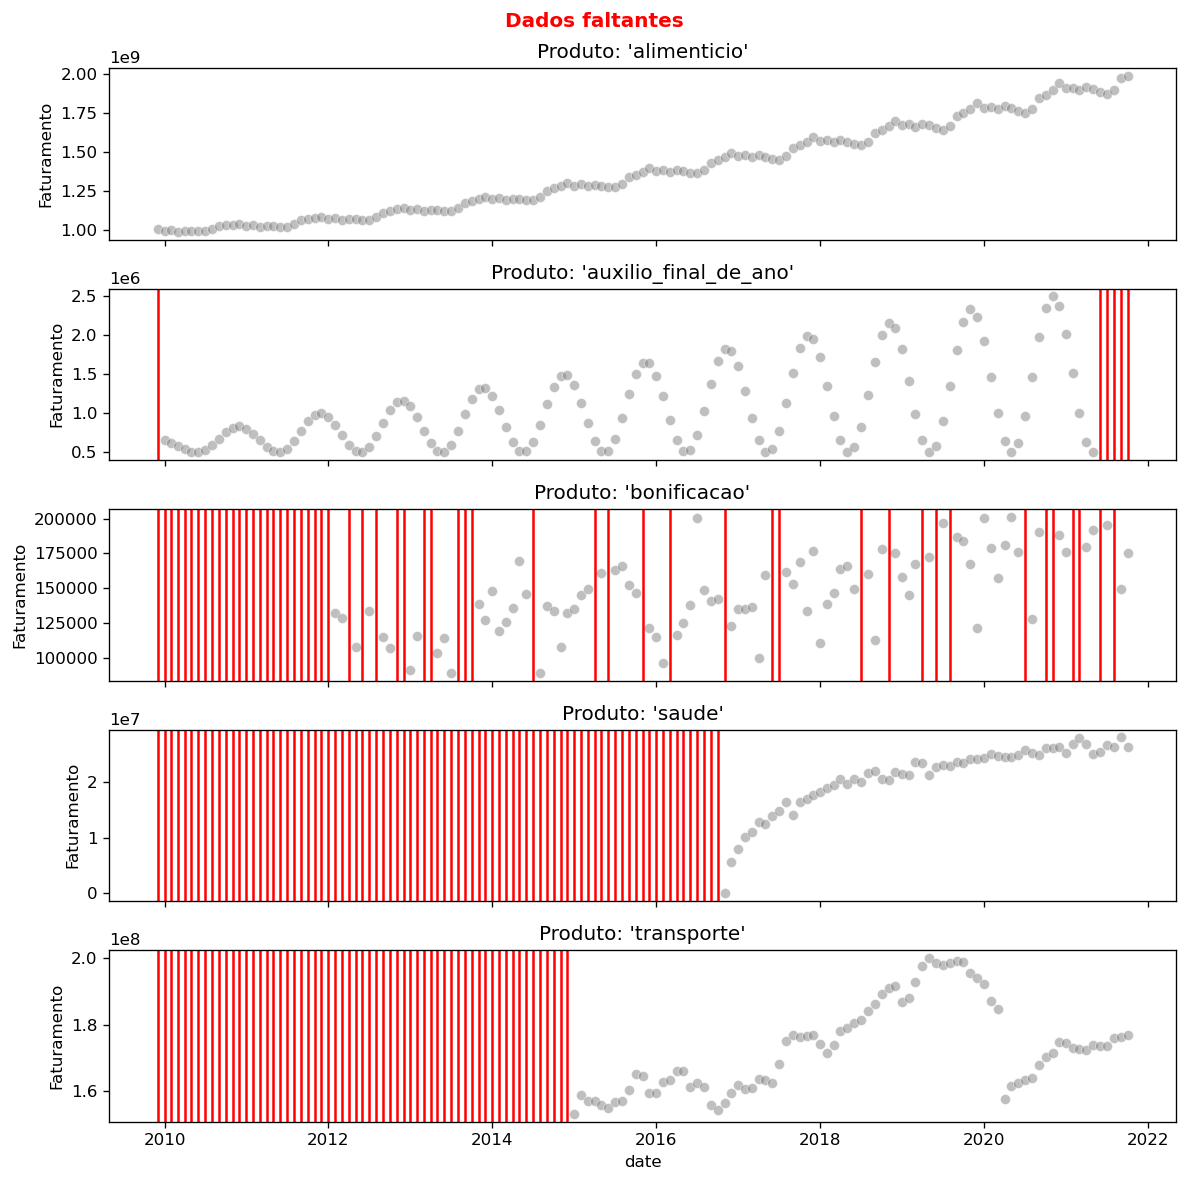

In [12]:
py_scripts.plots.dados_faltantes(tswide)

Vamos agora reconstruir o dicionário `tsd` após completar os valores faltantes.

In [13]:
tsd = {}
for produto in produtos:
    sprod = tswide[produto].dropna()
    sprod.name = f'faturamento_{produto}'
    tsd[produto] = sprod

sprodtotal = tswide.sum(axis = 'columns')
tsd['total'] = sprodtotal

Por fim, vamos salvar os dados limpos e pré-processados.

In [14]:
sim_ts = py_scripts.transform.wide2long(tswide)

# salvar
sim_ts.to_csv(r'../data/sim_ts_limpo.csv', index = False)

## Próximos passos

Em seguida, vamos realizar a análise esxploratória dos dados do faturamento total e segregado por cada produto.